# Exploring differences in word frequencies used between corpuses

## Graphs and visuals

Lets generate some visualizations showing which words are more likely to show up in each corpus, as well as find ones that tend to be more prominent in only one

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.feature_extraction import text 

In [2]:
fn_df = pd.read_csv("./firstnames.csv")
ln_df = pd.read_csv("./censusSurnames.csv")

In [3]:
# Add names to stop words
name_list = fn_df["firstname"].tolist() + ln_df["surname"].tolist()
test = CountVectorizer(stop_words="english")
test1 = test.fit_transform(name_list)
word_list = test.get_feature_names_out()
name_stop_words = word_list.tolist()
STOP_WORDS = list(text.ENGLISH_STOP_WORDS.union(name_stop_words))

In [4]:
# Build a dictionary of all the words in the documents used in the "Black-or-African-American" folder
# mapping each word to the number of times it was seen.
# ex.
# print(b_word_freq) # prints a dict showing that the word abdominal appeared 410 times
# { ..., 'abdominal': 410, ...}
folder_location = os.path.join("documents", "Black-or-African-American")
docs = []
for filename in os.listdir(folder_location):
    f = os.path.join(folder_location, filename)
    # checking if it is a file
    if os.path.isfile(f):
        docs.append(open(f))
cv = CountVectorizer(input="file", stop_words=STOP_WORDS)
cv_fit = cv.fit_transform(docs)
word_list = cv.get_feature_names_out()
count_list = cv_fit.toarray().sum(axis=0)

for fh in docs:
    fh.close()

b_word_freq = dict(zip(word_list, count_list))

In [5]:
# Build a dictionary of all the words in the documents used in the "White-or-Caucasian" folder
folder_location = os.path.join("documents", "White-or-Caucasian")
docs = []
for filename in os.listdir(folder_location):
    f = os.path.join(folder_location, filename)
    # checking if it is a file
    if os.path.isfile(f):
        docs.append(open(f))
cv = CountVectorizer(input="file", stop_words=STOP_WORDS)
cv_fit = cv.fit_transform(docs)
word_list = cv.get_feature_names_out()
count_list = cv_fit.toarray().sum(axis=0)

for fh in docs:
    fh.close()

w_word_freq = dict(zip(word_list, count_list))

[Text(0.5, 1.0, 'w word freq')]

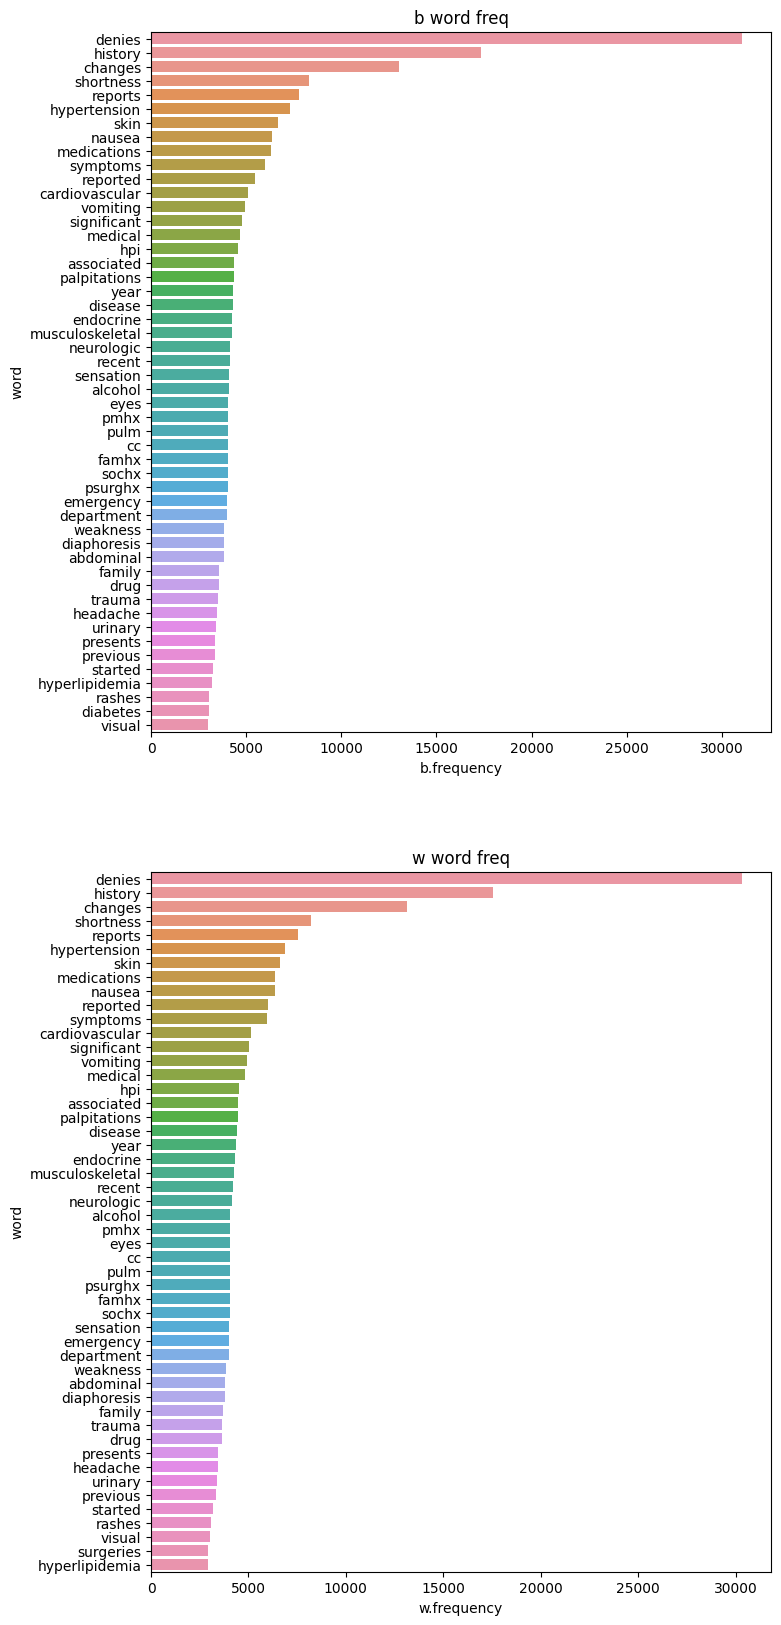

In [6]:
# Quick plot to see which words are used most in each data set
b_word_freq_df = pd.DataFrame(
    b_word_freq.items(), columns=["word", "b.frequency"]
).sort_values(by="b.frequency", ascending=False)
w_word_freq_df = pd.DataFrame(
    w_word_freq.items(), columns=["word", "w.frequency"]
).sort_values(by="w.frequency", ascending=False)
fig, axes = plt.subplots(2, 1, figsize=(8, 20))
sns.barplot(ax=axes[0], x="b.frequency", y="word", data=b_word_freq_df.head(50)).set(
    title="b word freq"
)
sns.barplot(ax=axes[1], x="w.frequency", y="word", data=w_word_freq_df.head(50)).set(
    title="w word freq"
)

In [7]:
# Inner join the b and w tables on words to combine freq between both tables
wf_df = w_word_freq_df.merge(b_word_freq_df, how="inner", on="word")

In [8]:
# We don't want to sort on the most common freq for w vs b especially if the frequencies are similar, instead we care about where these frequencies differ
# Create a new column that calculates the difference in freq of words between datasets and sort by the diff
wf_df["w.frequency_pct"] = wf_df["w.frequency"] / wf_df["w.frequency"].sum()
wf_df["b.frequency_pct"] = wf_df["b.frequency"] / wf_df["b.frequency"].sum()
wf_df["frequency_pct_diff"] = wf_df["b.frequency_pct"] - wf_df["w.frequency_pct"]
wf_df["frequency_pct_diff_abs"] = wf_df["frequency_pct_diff"].abs()
# Sort by largest values in absolue difference
wf_df.sort_values(by="frequency_pct_diff", ascending=False).head(10)

,word,w.frequency,b.frequency,w.frequency_pct,b.frequency_pct,frequency_pct_diff,frequency_pct_diff_abs
0,denies,30306,31027,0.059492,0.060693,0.001201,0.001201
5,hypertension,6869,7304,0.013484,0.014288,0.000803,0.000803
49,hyperlipidemia,2912,3196,0.005716,0.006252,0.000535,0.000535
55,mg,2645,2890,0.005192,0.005653,0.000461,0.000461
4,reports,7537,7755,0.014796,0.015170,0.000374,0.000374
70,female,2088,2252,0.004099,0.004405,0.000306,0.000306
50,diabetes,2884,3048,0.005661,0.005962,0.000301,0.000301
57,10,2607,2770,0.005118,0.005419,0.000301,0.000301
154,diagnosed,663,813,0.001302,0.001590,0.000289,0.000289
103,mother,1138,1275,0.002234,0.002494,0.000260,0.000260


In [9]:
# First order frequencies by magnature of difference (absolute value), take the top 200 words with the greatest difference,
# then re-sort by actual difference so when we plot the values will be sequential from smallest to largest bars
most = (
    wf_df.sort_values(by="frequency_pct_diff_abs", ascending=False)
    .head(200)
    .sort_values(by="frequency_pct_diff", ascending=False)
)

chart_data = {}

# Create a map with the word as the frequency, and the magnitude vector as the value\
# a vector of [0, n] will plot a blue bar
# a vector of [n, 0] will plot an orange bar
# a vector with a negative n [-n, 0] will plot a bar on the left
# a vector with a positive n [n, 0] will plot a bar on the right
# {"word": [-1, 0]} will plot an orange bar for "word" on the left of 0 with length 1
# {"word": [0, 0.5]} will plot a blue bar for "word" on the right of 0 with length 0.5
# in order to generate a good Positive Negative bar chart, we assign b freq to the left side (negative)
# and w freq to the right side (positive)
for row in most.iterrows():
    if row[1]["w.frequency_pct"] > row[1]["b.frequency_pct"]:
        # orange bars
        chart_data[row[1]["word"]] = [
            row[1]["w.frequency_pct"] - row[1]["b.frequency_pct"],
            0,
        ]
    else:
        # blue bars
        chart_data[row[1]["word"]] = [
            0,
            -(row[1]["b.frequency_pct"] - row[1]["w.frequency_pct"]),
        ]

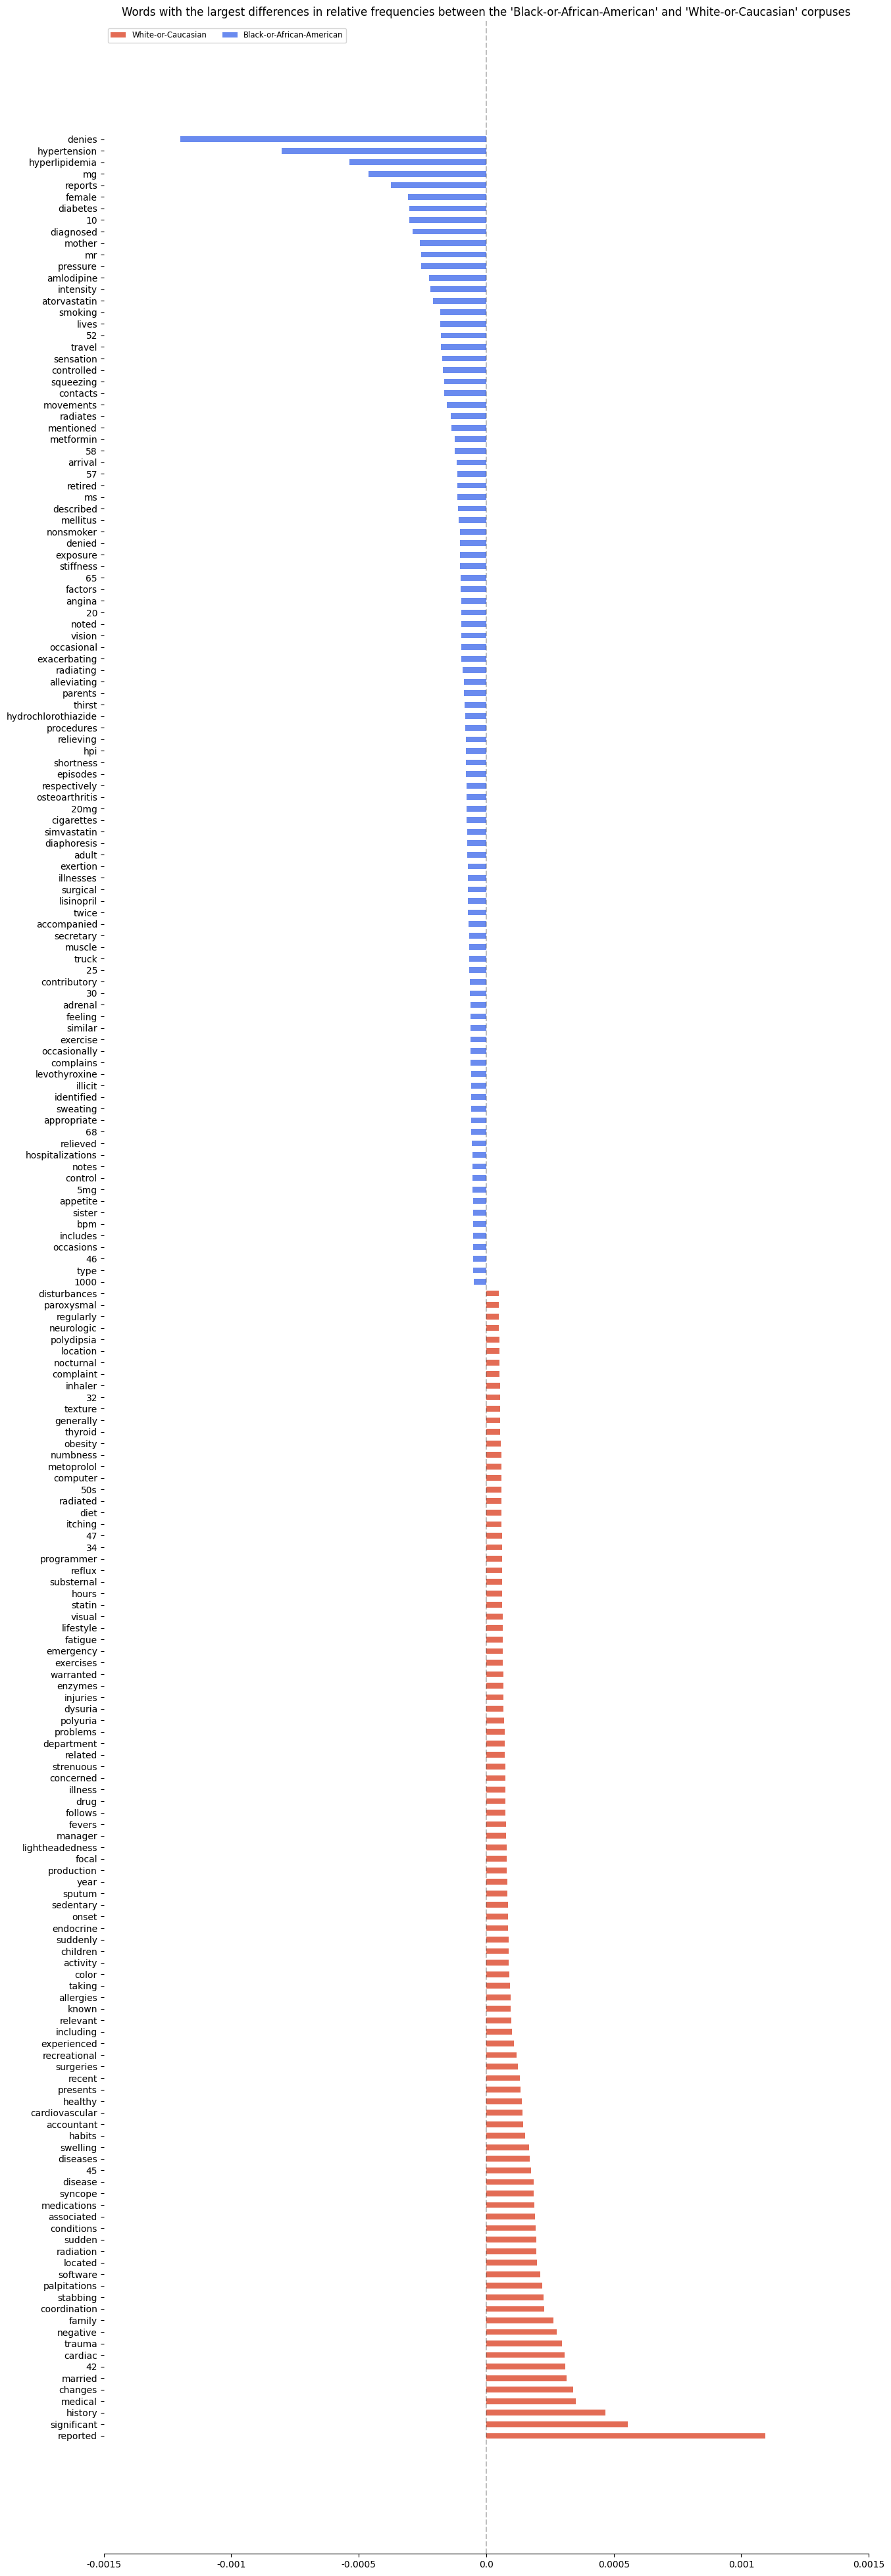

In [10]:
# Positive Negative Bar Chart to better visualize where word frequencies diverge between data sets
# Based on https://stackoverflow.com/a/69976552/11407943
import numpy as np
import matplotlib.pyplot as plt


category_names = ["White-or-Caucasian", "Black-or-African-American"]
results = chart_data


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = 0  # data[:, range(middle_index)].sum(axis=1) # + data[:, middle_index]/2

    # Color Mapping
    category_colors = plt.get_cmap("coolwarm_r")(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 50))

    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

    # Add Zero Reference Line
    ax.axvline(0, linestyle="--", color="black", alpha=0.25)

    # X Axis
    ax.set_xlim(-0.0015, 0.0015)
    # ax.set_xticks(np.arange(-0.0035, 0.0035, 0.003))
    ax.xaxis.set_major_formatter(lambda x, pos: str(x))

    # Y Axis
    ax.invert_yaxis()

    # Remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Ledgend
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 0.99),
        loc="lower left",
        fontsize="small",
    )

    # Set Background Color
    fig.set_facecolor("#FFFFFF")

    return fig, ax


fig, ax = survey(results, category_names)
plt.title(
    "Words with the largest differences in document frequencies between the 'Black-or-African-American' and 'White-or-Caucasian' corpuses"
)
plt.show()

In [11]:
most

,word,w.frequency,b.frequency,w.frequency_pct,b.frequency_pct,frequency_pct_diff,frequency_pct_diff_abs
0,denies,30306,31027,0.059492,0.060693,0.001201,0.001201
5,hypertension,6869,7304,0.013484,0.014288,0.000803,0.000803
49,hyperlipidemia,2912,3196,0.005716,0.006252,0.000535,0.000535
55,mg,2645,2890,0.005192,0.005653,0.000461,0.000461
4,reports,7537,7755,0.014796,0.015170,0.000374,0.000374
...,...,...,...,...,...,...,...
2,changes,13163,13035,0.025840,0.025498,-0.000341,0.000341
14,medical,4820,4657,0.009462,0.009110,-0.000352,0.000352
1,history,17526,17349,0.034404,0.033937,-0.000467,0.000467
12,significant,5034,4768,0.009882,0.009327,-0.000555,0.000555


In [12]:
len(docs)

4046

# T-test (independent)

In [13]:
# Note that we're removing stop words, which may influence our stats
folder_location = os.path.join("documents", "Black-or-African-American")
b_docs = []
for filename in os.listdir(folder_location):
    f = os.path.join(folder_location, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f) as doc:
            cv = CountVectorizer(input="file", stop_words=STOP_WORDS)
            cv_fit = cv.fit_transform([doc])
            word_list = cv.get_feature_names_out()
            count_list = cv_fit.toarray().sum(axis=0)
            b_word_freq = dict(zip(word_list, count_list))
            b_docs.append(b_word_freq)

In [14]:
folder_location = os.path.join("documents", "White-or-Caucasian")
w_docs = []
for filename in os.listdir(folder_location):
    f = os.path.join(folder_location, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f) as doc:
            cv = CountVectorizer(input="file", stop_words=STOP_WORDS)
            cv_fit = cv.fit_transform([doc])
            word_list = cv.get_feature_names_out()
            count_list = cv_fit.toarray().sum(axis=0)
            b_word_freq = dict(zip(word_list, count_list))
            w_docs.append(b_word_freq)

In [15]:
def run_test_on_word(word):
    b_freq_list_htn = []
    w_freq_list_htn = []
    for doc in b_docs:
        b_freq_list_htn.append(doc.get(word,0)/sum(doc.values()))
    
    for doc in w_docs:
        w_freq_list_htn.append(doc.get(word,0)/sum(doc.values()))
    # Non paired T-test, two individual groups
    test_result = scipy.stats.ttest_ind(b_freq_list_htn, w_freq_list_htn)
    return test_result

In [16]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
word_list = (wf_df.sort_values(by="frequency_pct_diff_abs", ascending=False)
                .sort_values(by="frequency_pct_diff", ascending=False)
            )["word"].tolist()
sig_count = 0
for word in word_list:
    if (run_test_on_word(word).pvalue < 0.01):
        print(f'There is a significant difference in the frequency of the word "{word}" with a p-value of {bcolors.OKGREEN + "{:0.3f}".format(run_test_on_word(word).pvalue)}' + bcolors.ENDC)
        sig_count = sig_count + 1
    elif (run_test_on_word(word).pvalue < 0.05):
        print(f'There is a significant difference in the frequency of the word "{word}" with a p-value of {"{:0.3f}".format(run_test_on_word(word).pvalue)}')
        sig_count = sig_count + 1
print(len(word_list))
print(sig_count)

There is a significant difference in the frequency of the word "hypertension" with a p-value of 0.000
There is a significant difference in the frequency of the word "hyperlipidemia" with a p-value of 0.001
There is a significant difference in the frequency of the word "mg" with a p-value of 0.015
There is a significant difference in the frequency of the word "female" with a p-value of 0.001
There is a significant difference in the frequency of the word "diabetes" with a p-value of 0.043
There is a significant difference in the frequency of the word "10" with a p-value of 0.019
There is a significant difference in the frequency of the word "diagnosed" with a p-value of 0.006
There is a significant difference in the frequency of the word "mother" with a p-value of 0.001
There is a significant difference in the frequency of the word "mr" with a p-value of 0.040
There is a significant difference in the frequency of the word "pressure" with a p-value of 0.009
There is a significant differen

# These results are just for exploratory analysis

![significant](https://imgs.xkcd.com/comics/significant.png)